# Adult Data and KModes

In this notebook, we'll apply some clustering algorithms to this dataset. Since we're using predominantly categorical data, we'll be using KModes, the categorical equivalent to KMeans.

As always, libraries first ...

In [104]:
# base libraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# stats
import scipy.stats as ss

# ml libraries
from kmodes.kmodes import KModes
import prince

# etc
from tqdm import tqdm
import itertools

... set the rng seed ...

In [2]:
rng_seed = 0
np.random.seed(rng_seed)

... then load the dataset:

In [171]:
df = pd.read_csv('adult_data.csv')

Let's again show the data, albeit briefly since this was already done in the SQL analysis.

First, show the columns, their types, and number of not-NaNs (should be 0):

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Next the stats for numericals cols:

In [5]:
display(df.describe())

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


... and their distributions:

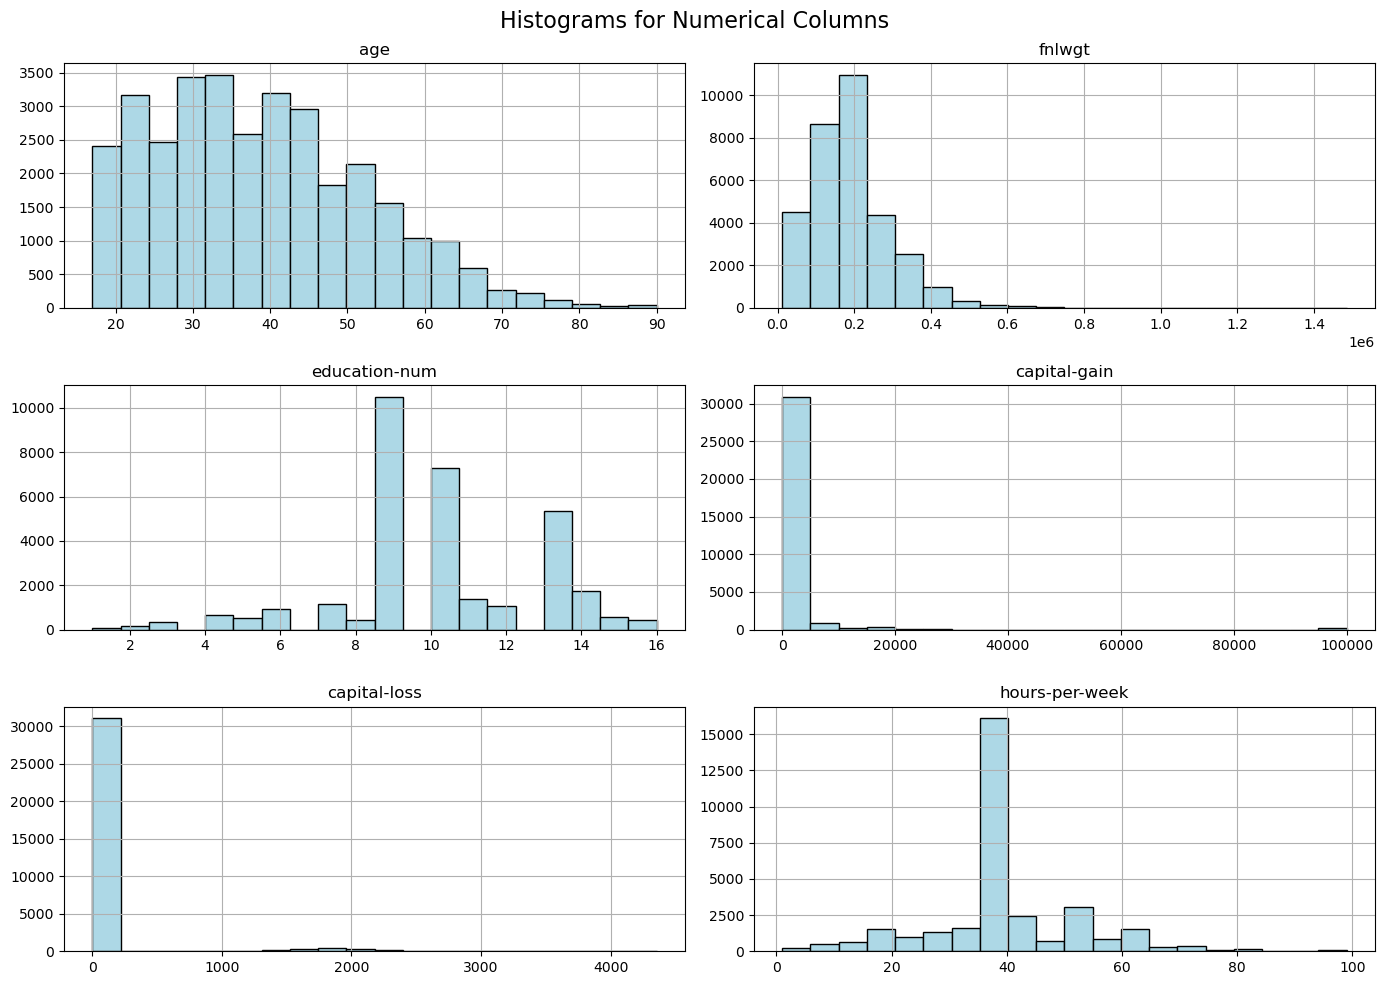

In [6]:
numerical_cols = df.dtypes[ df.dtypes != 'object' ].index.values
df[numerical_cols].hist(bins=20, figsize=(14, 10), color='lightblue', edgecolor='black')
plt.suptitle("Histograms for Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

Now to get the frequency-related stats for categorical cols (done by 'include' keyword):

In [7]:
display(df.describe(include='object'))

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


... and visualizing those as well:

In [133]:
# define func for plotting categories as pie charts
def pie_chart_categ(df, cols, fig_kws=None, ncols=None):
    if fig_kws is None: fig_kws = {}
    if ncols is None: ncols = 3
    
    # Get subplots based on len(cols) and ncols
    nrows = (len(cols) // ncols) + 1
    if len(cols) % ncols == 0: nrows -= 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
    axes1d = axes.flatten()

    # pie chart for each col
    for i, col in enumerate(cols):
        counts = df[col].value_counts()
        axes1d[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        axes1d[i].set_title(col)
    
    # hide unsused subplots
    for i in range(len(cols),len(axes)):
        axes1d[i].set_visible(False)
        
    fig.tight_layout()
    
    return fig, axes1d

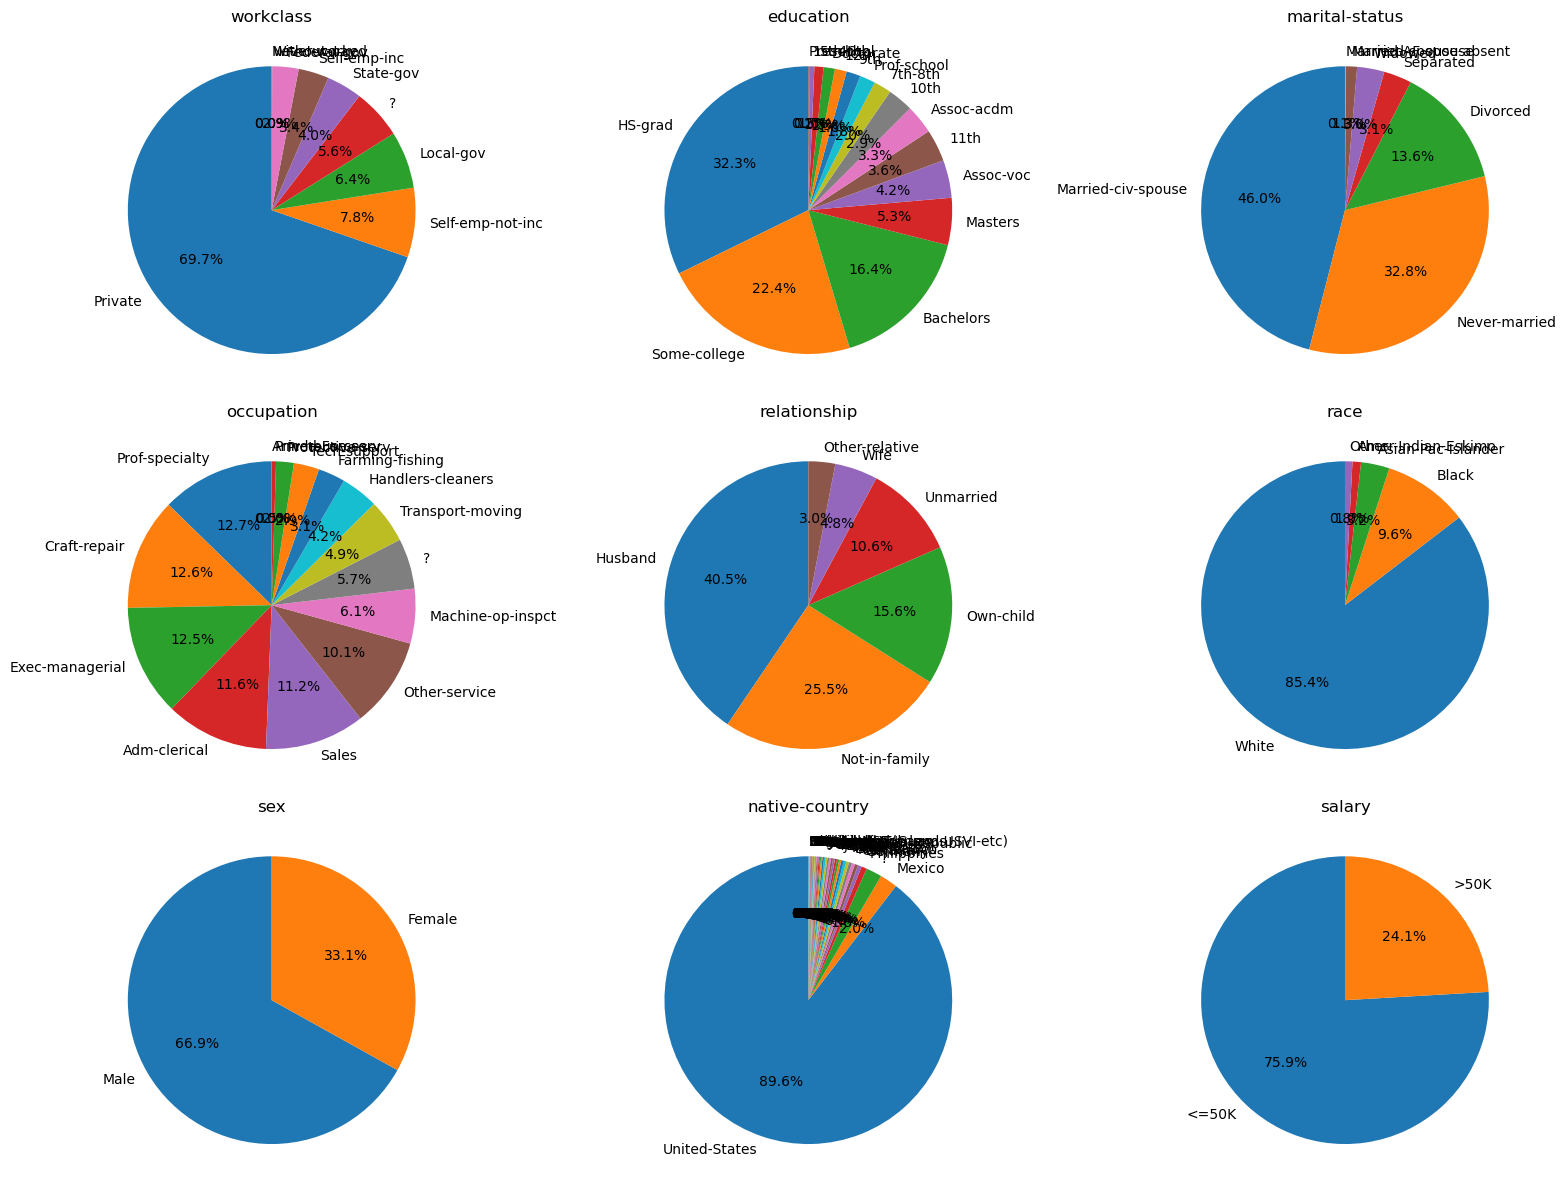

In [205]:
categ_cols = list(df.dtypes[ df.dtypes == 'object' ].index.values)
pie_chart_categ(df, categ_cols)
plt.show()

# KModes

## Pre-processing

We need to prepare the categories for our dataset. Using the Hamming distance to compare categories works but we can run into issues with too many unique categories. Similar to how outliers in a numerical disribution can skew clustering results, too many infrequent categories can skew categorical clustering results. Some columns, like native-country, race, and education have very rare categories. We need to ensure that there's sufficient representation per category (say, 5%) for most of columns we cluster. Categories falling under this frequency will be merged together. Also, do note that this idea is a quick hack and not always the best - this method would very likely take the extrema of the education column (so doctoral level and only early primary school level) and merge them together under 'Other'!

In [117]:
def merge_categs(df, col, merge_name='merge-other', cutoff=0.05):
    categs, counts = np.unique(df[col], return_counts=True)
    counts = counts / np.sum(counts) # normalize counts
    categs_to_merge = list( categs[ np.where( counts < cutoff )[0] ] )
    # build dict of [categ-to-be-removed] -> merge_name (e.g. 'too-small' -> 'Other')
    new_categs = { elem : merge_name for elem in categs_to_merge }
    # assign [categ-to-be-kept] -> [categ-to-be-kept] (e.g. 'Female' -> 'Female')
    kept_categs = list(np.setdiff1d( categs, categs_to_merge ))
    for categ_ in kept_categs:
        new_categs[categ_] = categ_
    # return copied column with new categories
    return df[col].apply(lambda x: new_categs[x])

We'll merge infrequency categories of the race, occupation, and native-country columns.

In [207]:
merge_cols = ['race','occupation','native-country']
for col in merge_cols:
    df[col+'_merged'] = merge_categs(df, col)

And let's visualize the categories again:

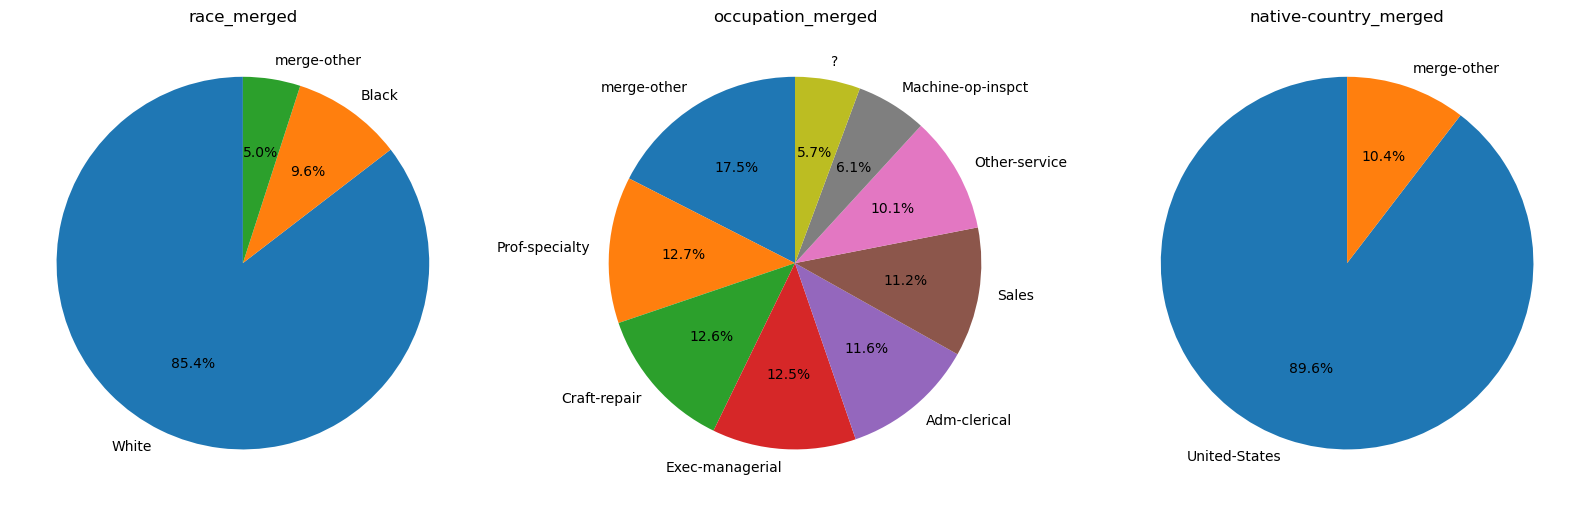

In [208]:
merged_cols = [elem for elem in df if 'merged' in elem]
pie_chart_categ(df, merged_cols)
plt.show()

Next we need to see if our columns are correlated - KModes isn't as impacted as KMeans is with correlated features (since we're using Hamming distance instead of euclidean) but strong correlations can still create some issues. We can use Cramer's V (a modified chi-square test) to see if the variables are correlated then visualize it with a heatmap.

In [209]:
# calculate cramers v
# taken directly from relevant stackexchange question:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def cramers_v_corrected(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# build matrix of correlations via cramers v
def categ_corr_mat(df, cols):
    corrM = np.ones((len(cols), len(cols)))  # init to ones for sake of main diagonal
    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        confusion_matrix = pd.crosstab(df[col1], df[col2])
        corrM[idx1, idx2] = cramers_v_corrected(confusion_matrix)
        corrM[idx2, idx1] = corrM[idx1, idx2]  # make symmetric
    return pd.DataFrame(corrM, index=cols, columns=cols)

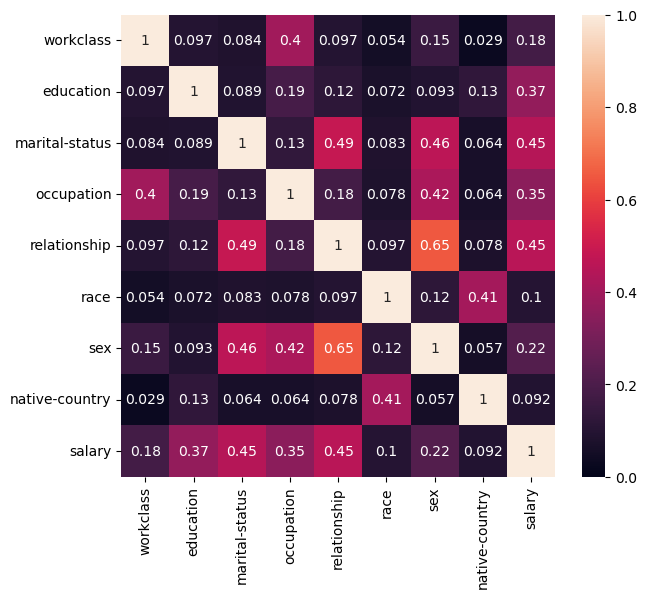

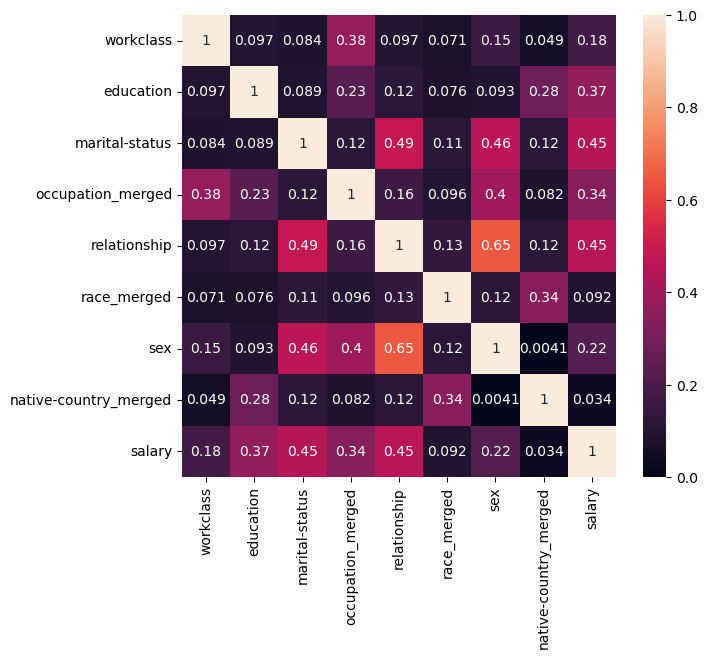

In [213]:
# show plot of corr over original cols
fig, ax = plt.subplots(figsize=(7, 6))
categ_corr_df = categ_corr_mat(df, categ_cols)
ax = sns.heatmap(categ_corr_df, annot=True, ax=ax,
                 vmax=1, vmin=0)
    
# get cols of original data vs including merged cols
new_categ_cols = [ elem for elem in categ_cols ]
for col in ['race','occupation','native-country']:
    new_categ_cols[ new_categ_cols.index( col ) ] = col+'_merged'
# show corr over merged cols
fig, ax = plt.subplots(figsize=(7, 6))
categ_corr_df = categ_corr_mat(df, new_categ_cols)
ax = sns.heatmap(categ_corr_df, annot=True, ax=ax,
                 vmax=1, vmin=0)

The category merging slightly reduced the correlations in some places but also increased it in others (especially since it turned native-country into a binary variable).

From the heatmap we can see that the following columns are all correlated:

1. workclass and occupation

2. education and salary

3. marital status, relationship, sex, and salary

4. occupation and sex

5. race and native-country

In general, we can resolve these correlations in different ways - which will lead to very different clustering methods:

1. For each strongly correlated pair, remove one of the two.

2. Get a linear combination of features that forms an orthonormal (and hence, uncorrelated) feature set (a categorical version of Principal Component Analysis [PCA]) - the categorical equivalent is Multiple Correspondence Analysis

This notebook focuses on using KModes, so we won't go the latter route - but just presenting it to note that it's possible. Since we're not as worried about correlations with KModes, we'll only remove 'sex' and 'marital-status' since these have lots of overlap and correlation.

####  *As a brief example, see below for going from a categorical to a numerical space - MCA side example*

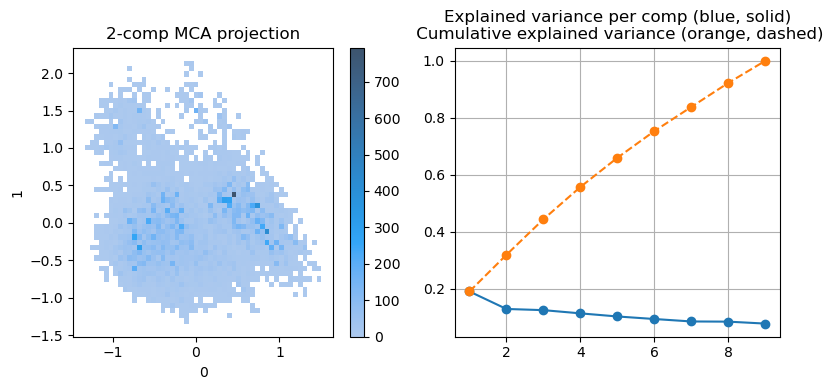

In [284]:
### Results here not used for KModes clustering or the rest of the notebook - just to briefly
### illustrate another way to cluster categorical data by another direction!
### --- If you had mixed-data, you could try Factor Analysis of Mixed Data (FAMD) instead

# initialize and train MCA
mca = prince.MCA(
    n_components=len(categ_cols),
    n_iter=10,
    copy=True,
    random_state=rng_seed
                 ).fit(df[categ_cols])

# project into lower dimensional space (categorical -> numeric)
mca_transformed = mca.transform(df[categ_cols])

# get relative proportions of MCA eigenvalues as well as relative cumulative sum
rel_eigen = mca.eigenvalues_ / np.sum(mca.eigenvalues_)
rel_cum_eigen = np.cumsum(mca.eigenvalues_) / np.sum(mca.eigenvalues_)

# show numeric projection of first 2 components and explained variance plots
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns_hist = sns.histplot(mca_transformed,x=0,y=1,ax=axes[0], bins=50, cbar=True)
axes[1].plot( np.arange(rel_eigen.shape[0])+1, rel_eigen, marker='o' )
axes[1].plot( np.arange(rel_eigen.shape[0])+1, rel_cum_eigen, marker='o', ls='dashed' )
axes[1].grid()
axes[0].set_title('2-comp MCA projection')
axes[1].set_title('Explained variance per comp (blue, solid)\n Cumulative explained variance (orange, dashed)')
fig.tight_layout()
plt.show()

The almost straight line of cumulative variances indicates an almost uniform variance across the columns (9 comps -> each comp has (1/9) fractional variance if truly uniform). But the last few components do show notably smaller variance contributions. Also, note that if you merged categories from columns to reduce cardinality, these **will** change - usually not going to be too bad as long as it's not extreme though.

## Clustering

100%|████████████████████████████████████████████| 9/9 [23:25<00:00, 156.20s/it]


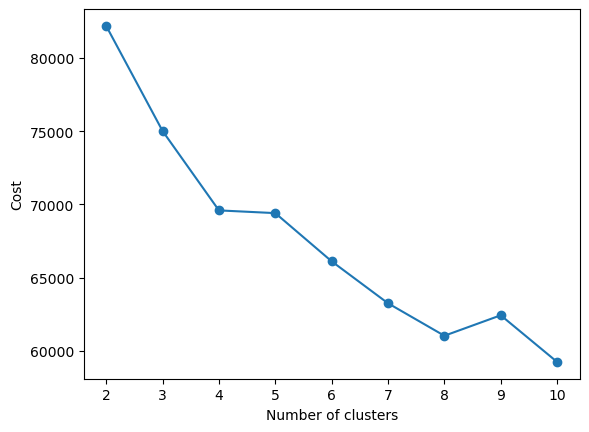

In [285]:
# using the columns that have *merged* categories!
cluster_cols = [ elem for elem in new_categ_cols if elem not in ('sex','marital-status') ]

max_k = 10
clusters = np.arange(2,max_k+1)

costs = []
models = {}
for k in tqdm( clusters ):
    km = KModes(n_clusters=k, init='Huang', n_init=10, verbose=0)
    km.fit(df[cluster_cols])
    models[k] = km
    costs.append(km.cost_)

plt.plot(clusters, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

Elbow-method stipulates selecting the model corresponding to the inertia (or here, the Hamming distance) where additional clusters deliver diminishing returns. There are additional metrics to validate clustering solutions, but many of them have certain assumptions (silhouette score among them assumes a euclidean distance, but we're working with hamming distances). We can extend the Davies-Buoldin Index (DBI) to KModes, but this requires a justification as DBI uses two concepts: (1) a distance to distinguish similar vs dissimilar points and (2) a "center" of a cluster.

**Categorical distance**

The Hamming distance is just such a distance in that it calculates the number of "mismatches" between two sequences. Some examples:

1. Two binary sequences of length 3 [a, a, b] and [b, a, b] have a hamming distance of 1 because of the mis-match in the 0th index. If the sequences are exactly the same, the distance is 0.

2. For our data, if we were exclusively looking at race, salary, and sex and we had the two sequences \['White', '<=\\$50k', 'Female'\] and \['Black', '>\\$50k', 'Female'\], the hamming distance would be 2 because of the differences in the 0th and 1st indices.

**Categorical center**

The "center" that is used in standard euclidean distance-based metrics is the average of the data in the cluster. While the average doesn't extend well to categorical space ("what's the average between 'Sales', 'Exec-managerial' and 'Craft-repair' categories?"), we can instead use the mode of the data (the most frequent category). For example, the mode of the binary categories \['>\\$50k', 'Male'\], \['>\\$50k', 'Male'\], \['>\\$50k', 'Female'\], and \['<=\\$50k', 'Male'\] would be \['>\\$50k', 'Male'\].

**Davies-Bouldin Index**

The index requires computing $R_{i,j} = \frac{S_i + S_j}{M_{i,j}}$ for each pair of clusters $i,j$ and then the index is the average of $R_{i,j}$. $S_i$ is the average intra-cluster distance for cluster $i$, which here is the average hamming distance in each cluster. $M_{i,j}$ is the distance between the centroids of clusters $i$ and $j$. So for hypothetical clusters 1 and 2, if $S_1$ and $S_2$ were both small (meaning that those clusters had little variance, or were pretty compact) and $M_{i,j}$ was large (meaning that the centers of clusters 1 and 2 were far apart), then the index $R_{1,2} \sim \frac{small}{large} \sim$ very small. The smaller the index, the better. It's inconvenient to inspect $R_{i,j}$ for each pair of clusters, so when the number of clusters is greater than 2, we select $R_{i,j} = max( R_{i,q} )$ $\forall$ $q$ to get the worst case, then average these worst cases over all $i$ to get DBI = <$R_{i,j}$>.


In [290]:
# custom noramlized Hamming distance to get difference between point and "center" (i.e. categorical mode)
# e.g. hamming_dist = 2 on length-5 vector means norm hamming dist = 2 / 5 = 0.4
def hamming_dist_categ(point, mode):
    return np.sum(point != mode) / len(point)

# compute DBI for kmodes
def davies_bouldin_index_kmodes(X, labels, cluster_centers):
    n_clusters = cluster_centers.shape[0]
    
    # init intra- and inter-cluster distances
    S = np.zeros(n_clusters)
    M = np.zeros((n_clusters, n_clusters))
    
    # calc avg intra-cluster distance
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        mode = cluster_centers[i]
        S[i] = np.mean([hamming_dist_categ(point, mode) for point in cluster_points])
    
    # calc inter-cluster distance
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                M[i, j] = hamming_dist_categ(cluster_centers[i], cluster_centers[j])
    
    # calc R_ij for each cluster pair, then avg for index
    R = np.zeros(n_clusters)
    for i in range(n_clusters):
        R[i] = max((S[i] + S[j]) / M[i, j] for j in range(n_clusters) if i != j)
    return np.mean(R)

Now compute DBI for each trained kmodes model:

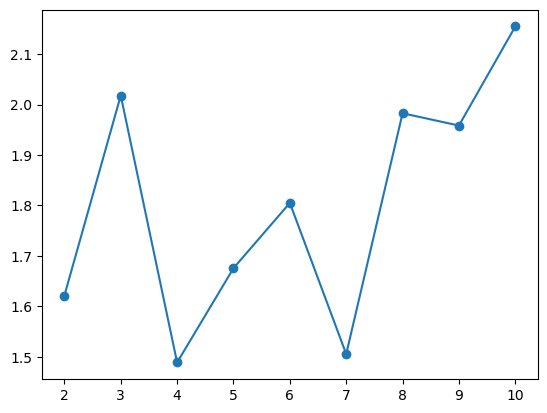

In [291]:
dbi = []
for k in clusters:
    dbi_ = davies_bouldin_index_kmodes(df[cluster_cols].to_numpy(),
                                       models[k].predict( df[cluster_cols] ),
                                       models[k].cluster_centroids_)
    dbi.append( dbi_ )
plt.plot(clusters, dbi, marker='o')

The clustering solutions for 4 and 7 clusters have comparable DBI. We can inspect both to see which one is best by looking at stacked bar charts of the categorical variables and also analyze the hamming distances per cluster. Additionally, since the "centers" are modes, we can much more easily interpret the cluster centers outright versus if it were KMeans.

Define the functions for plotting and hamming dist calculations first:

In [354]:
# show grouped bar charts of clusters
def compare_clusters_categs(df, cols, c_col, fig_kws=None):
    if fig_kws is None: fig_kws = {}
    fig, axes = plt.subplots(3,3, **fig_kws)
    axes1d = axes.flatten()
    for i, col in enumerate(cols):
        df_grouped = df.groupby([col, c_col]).size().unstack(fill_value=0)
        df_grouped.plot(kind='bar', stacked=True, colormap='tab20', ax=axes1d[i])
        if i > 0:
            axes1d[i].get_legend().remove()
    # hide unused subplots
    for i in range(len(cluster_cols),axes1d.shape[0]):
        axes1d[i].set_visible(False)
    fig.tight_layout()
    return fig, axes1d


# get hamming dist relative to each cluster center
def calc_hamming_dist(df, cluster_labels, cluster_centroids, cluster_cols):
    n_samples = df.shape[0]
    n_clusters = len(cluster_centroids)
    hamming_distances = np.zeros((n_samples, n_clusters))
    for i, row in tqdm(df[cluster_cols].iterrows(), total=n_samples): 
        for cluster_idx in range(n_clusters):
            centroid = cluster_centroids[cluster_idx]
            hamming_dist = hamming_dist_categ(row[cluster_cols], centroid)
            hamming_distances[i, cluster_idx] = hamming_dist
    return hamming_distances * len(cluster_cols)

### Visualizing 4-clusters solution:

,workclass,education,occupation_merged,relationship,race_merged,native-country_merged,salary
0,Private,Bachelors,Prof-specialty,Not-in-family,White,United-States,<=50K
1,Private,Some-college,Other-service,Own-child,White,United-States,<=50K
2,Private,Bachelors,Exec-managerial,Husband,White,United-States,>50K
3,Private,HS-grad,Craft-repair,Husband,White,United-States,<=50K


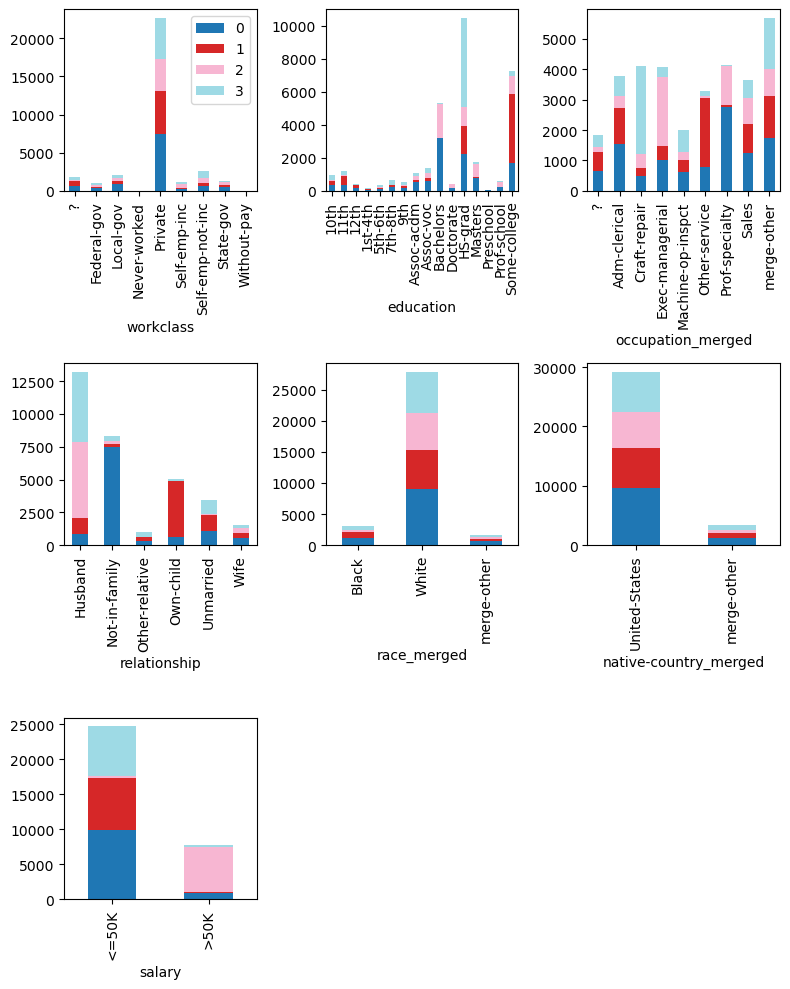

In [346]:
display( pd.DataFrame(models[4].cluster_centroids_, columns=cluster_cols) )
_ = compare_clusters_categs(df, cluster_cols, 
                            models[4].predict( df[cluster_cols] ),
                            fig_kws={'figsize':(8,10)})

In [355]:
# get hamming distances for all 4 clusters
df['c4'] = models[4].predict( df[cluster_cols] )
hdist4 = calc_hamming_dist(df,
                           df['c4'],
                           models[4].cluster_centroids_,
                           cluster_cols)
df['hd4'] = hdist4.min(axis=1)  # save min hamming dist per pt to df

100%|████████████████████████████████████| 32561/32561 [01:27<00:00, 372.58it/s]


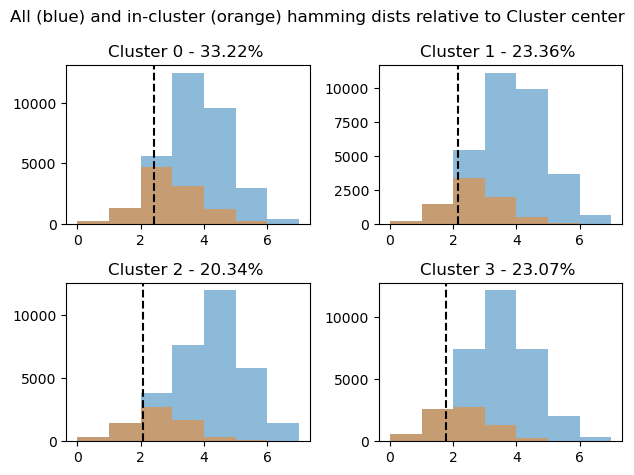

In [372]:
# show hamming dist for 4 clusters
fig, axes = plt.subplots(2,2)
axes1d = axes.flatten()
for i in range(4):
    bins = np.arange(0,len(cluster_cols)+1)  # max ham dist possible for length-7 vector is 7
    # show hist of all dists relative to center
    axes1d[i].hist( hdist4[:,i], alpha=0.5, bins=bins )
    # then just show dists of in-cluster pts
    mask = df['c4'] == i
    axes1d[i].hist( df['hd4'][mask], alpha=0.5, bins=bins )
    axes1d[i].axvline( df['hd4'][mask].mean(), c='black', ls='dashed' )
    axes1d[i].set_title(f'Cluster {i} - {100*mask.sum() / df.shape[0]:.2f}% ')
fig.suptitle('All (blue) and in-cluster (orange) hamming dists relative to Cluster center')
plt.tight_layout()

### Visualizing 7-clusters solution:

,workclass,education,occupation_merged,relationship,race_merged,native-country_merged,salary
0,Private,Bachelors,Prof-specialty,Husband,White,United-States,>50K
1,Private,HS-grad,Other-service,Unmarried,Black,United-States,<=50K
2,Private,Some-college,Adm-clerical,Own-child,White,United-States,<=50K
3,Private,Bachelors,merge-other,Not-in-family,White,merge-other,<=50K
4,Private,HS-grad,Craft-repair,Husband,White,United-States,<=50K
5,Self-emp-not-inc,HS-grad,merge-other,Husband,White,United-States,<=50K
6,Private,HS-grad,merge-other,Not-in-family,White,United-States,<=50K


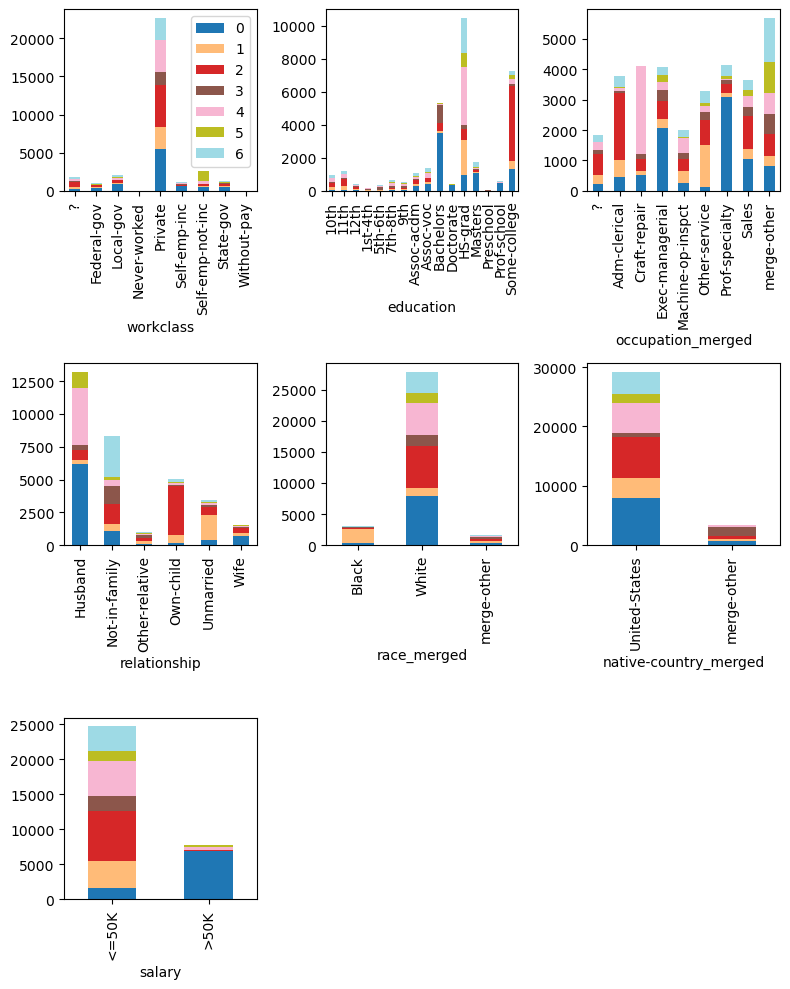

In [345]:
display( pd.DataFrame(models[7].cluster_centroids_, columns=cluster_cols) )
_ = compare_clusters_categs(df, cluster_cols, 
                            models[7].predict( df[cluster_cols] ),
                            fig_kws={'figsize':(8,10)})

In [361]:
# get hamming distances for all 7 clusters
df['c7'] = models[7].predict( df[cluster_cols] )
hdist7 = calc_hamming_dist(df,
                           df['c7'],
                           models[7].cluster_centroids_,
                           cluster_cols)
df['hd7'] = hdist7.min(axis=1)  # save min hamming dist per pt to df

100%|████████████████████████████████████| 32561/32561 [02:37<00:00, 206.11it/s]


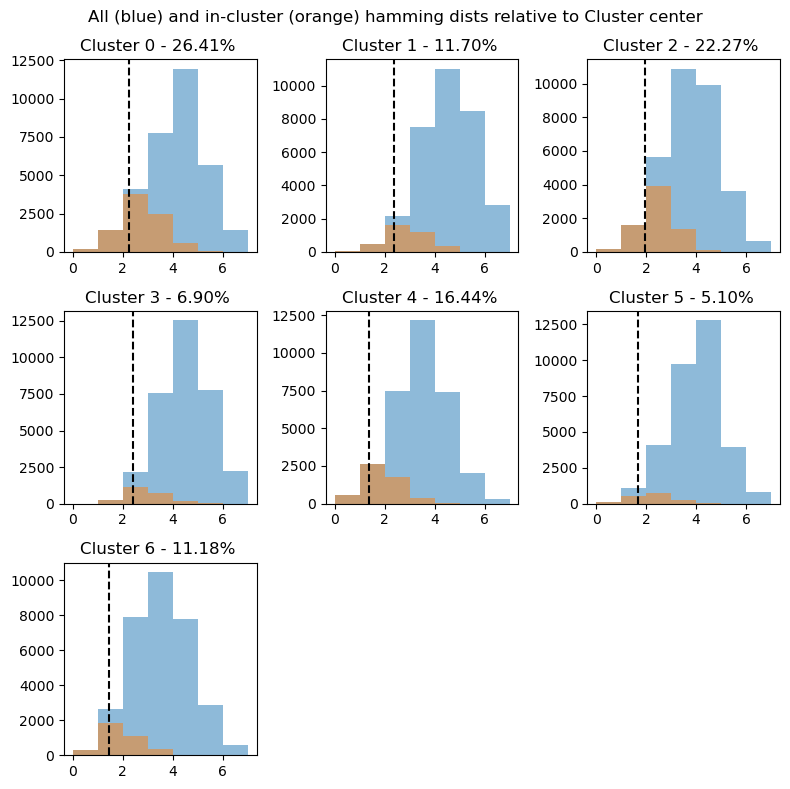

In [371]:
# show hamming dist for 7 clusters
fig, axes = plt.subplots(3,3, figsize=(8,8))
axes1d = axes.flatten()
for i in range(7):
    bins = np.arange(0,len(cluster_cols)+1)  # max ham dist possible for length-7 vector is 7
    # show hist of all dists relative to center
    axes1d[i].hist( hdist7[:,i], alpha=0.5, bins=bins )
    # then just show dists of in-cluster pts
    mask = df['c7'] == i
    axes1d[i].hist( df['hd7'][mask], alpha=0.5, bins=bins )
    axes1d[i].axvline( df['hd7'][mask].mean(), c='black', ls='dashed' )
    axes1d[i].set_title(f'Cluster {i} - {100*mask.sum() / df.shape[0]:.2f}% ')
for i in range(7,9):
    axes1d[i].set_visible(False)
fig.suptitle('All (blue) and in-cluster (orange) hamming dists relative to Cluster center')
fig.tight_layout()

# Clustering Results Discussion

The 4-clusters and 7-clusters solution had comparablly low DBI values, indicating similar quality in their solutions.

**4-clusters:**

In [366]:
# modes for k = 4
display( pd.DataFrame(models[4].cluster_centroids_, columns=cluster_cols) )

,workclass,education,occupation_merged,relationship,race_merged,native-country_merged,salary
0,Private,Bachelors,Prof-specialty,Not-in-family,White,United-States,<=50K
1,Private,Some-college,Other-service,Own-child,White,United-States,<=50K
2,Private,Bachelors,Exec-managerial,Husband,White,United-States,>50K
3,Private,HS-grad,Craft-repair,Husband,White,United-States,<=50K


The clusters exhibited similar modes for the workclass, race_merged, and native-country_merged columns, meaning that granularity with respect to those columns are not present in the solution, so we will be looking at distinctions in the education, occupation_merged, relationship, and salary. From the bar charts and the cluster centroids, we can see that

1. Cluster 2 (Pink) corresponds to husbands with >\\$50k in salary with a bachelors. The >\\$50k salary group is dominated by this cluster, so it's likely that many of the higher educational levels also belong to this cluster.

2. Cluster 0 (Blue) corresponds to those not currently part of a family, having <=\\$50k salary, and also having a bachelors degrees. The <=\\$50k salary group is pretty evenly split between this cluster and clusters 1 and 3.

3. Cluster 1 (Red) corresponds to those who have a child (but are not part of a family), having <=\\$50k salary, and have some college education.

4. Cluster 3 (Light blue) corresponds to those with a high school education, having <=\\$50k salary, and are a husband.

So overall, it seems like clusters 2 and 3 represent males with >\\$50k and <=\\$50k in salary, respectively, which also shows the positive correlation between higher education level and salary. Clusters 0 and 1 captured the 'not-in-family' and having a child subsets of the <=\\$50k salary distribution.

**7-clusters:**

In [367]:
# modes for k = 7
display( pd.DataFrame(models[7].cluster_centroids_, columns=cluster_cols) )

,workclass,education,occupation_merged,relationship,race_merged,native-country_merged,salary
0,Private,Bachelors,Prof-specialty,Husband,White,United-States,>50K
1,Private,HS-grad,Other-service,Unmarried,Black,United-States,<=50K
2,Private,Some-college,Adm-clerical,Own-child,White,United-States,<=50K
3,Private,Bachelors,merge-other,Not-in-family,White,merge-other,<=50K
4,Private,HS-grad,Craft-repair,Husband,White,United-States,<=50K
5,Self-emp-not-inc,HS-grad,merge-other,Husband,White,United-States,<=50K
6,Private,HS-grad,merge-other,Not-in-family,White,United-States,<=50K


As expected, one of the solutions for a higher number of clusters reflects greater granularity of the dataset. There is no column in which all the modes are the same, so each cluster can have a better interpretation. What immediately stands out relative to the previous solution is that there are additional clusters that capture difference in race_merged and native-country_merged. Let's consider each cluster individually:

1. Cluster 0 (Blue) is the only cluster with >\\$50k salary. Given the correlations between both sex and salary as well as race and salary, it is unsurprising that the cluster's mode for relationship and race_merged is 'Husband' and 'White'.

2. Cluster 1 (...yellow?) is the only cluster that had a non-white race_merged mode, specifically corresponding to 'Black'. It is also the only one with the 'Unmarried' mode under relationship. From the histogram of inter-cluster hamming distance, this cluster has one of the largest inter-cluster hamming distance between the 7 clusters, indicating wide variance in the distribution.

3. Cluster 2 (Red) represents people who have some collegiate education and those who have a child.

4. Cluster 3 (Brown) corresponds most with those not born in the United States. This histogram of hamming distances for this cluster shows a skewed distribution, indicating the presence of outliers (likely others not born in the U.S. but with differing levels of education, occupation, or salary).

5. Cluster 4 (Pink) corresponds to the (partial) subset of <=\\$50k salary, White, husbands that have a Craft-repair occupation and have a high school education. This cluster is also the most compact as it has the lowest average hamming distance.

6. Cluster 5 (Green) is the only cluster that does not have a 'Private' category in the workclass column and is the least-populated cluster.

7. Cluster 6 (Light blue) represents those with a 'Not-in-family' status and who do not have one of the larger occupations ('merge-other'). Like clusters 4 and 5, it is quite compact and has a low intra-cluster averaging hamming distance.

Overall, the proportions of the categories amongst the columns are captured well by the modes. 3 of the 7 clusters have common modes of 'White' and 'Husband' with of those three clusters focusing on a different categorical subset (0 looks at high salary, 4 at occupation_merged, and 5 at workclass). 2 clusters map to categories unexplored in the previous solution (1 being 'Black' under race_merged and 3 being 'merge_other' under native-country_merged). Cluster 2 represents the 'Own-child' and 'Some-college' categories under relationship and education and seems quite similar to cluster 1 of the 4-cluster solution presented earlier. And last, cluster 6 represents the differences in occupation_merged and relationship with the 'merge-other' and 'Not-in-family' modes.

Between these two solution, the 7-cluster solution seems superior. Even greater granularity and interpretability could likely be done if a layered clustering approach using both KModes and Hierarchical Clustering were used instead.